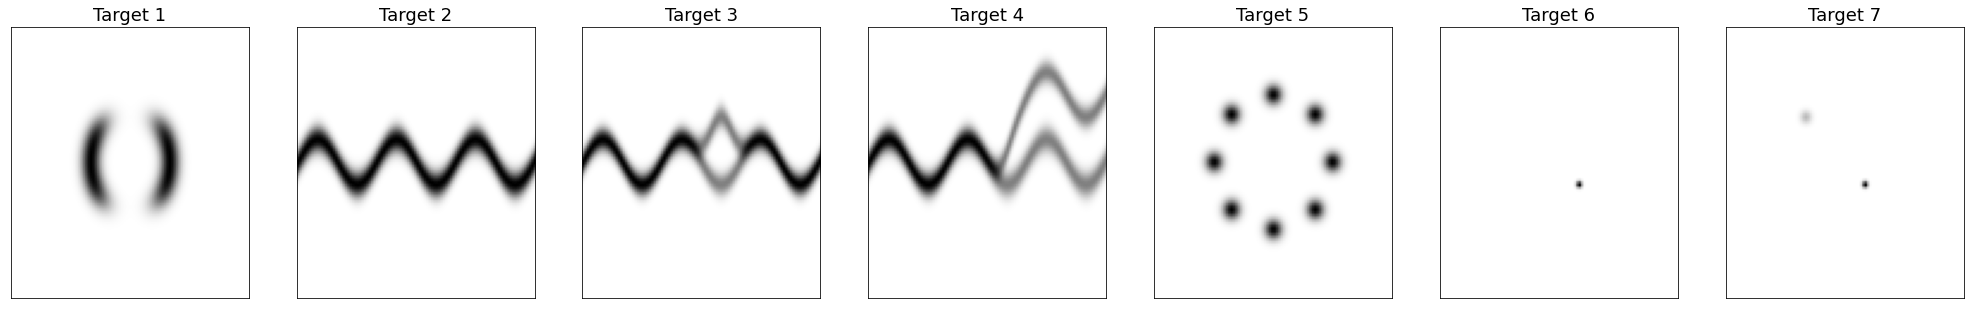

In [1]:
# target density plots
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import math, os, pickle
%matplotlib inline

from utils.targets import synthetic_targets 
from utils.plots import plot_energy_heatmap

targets = synthetic_targets.keys()
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(5*7, 5))
plt.xticks([])
for i, t in enumerate(targets):
    log_density = synthetic_targets[t]
    log_density.cuda()
    plot_energy_heatmap(ax[i], log_density, x=None)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('Target {}'.format(i + 1), fontsize=18)


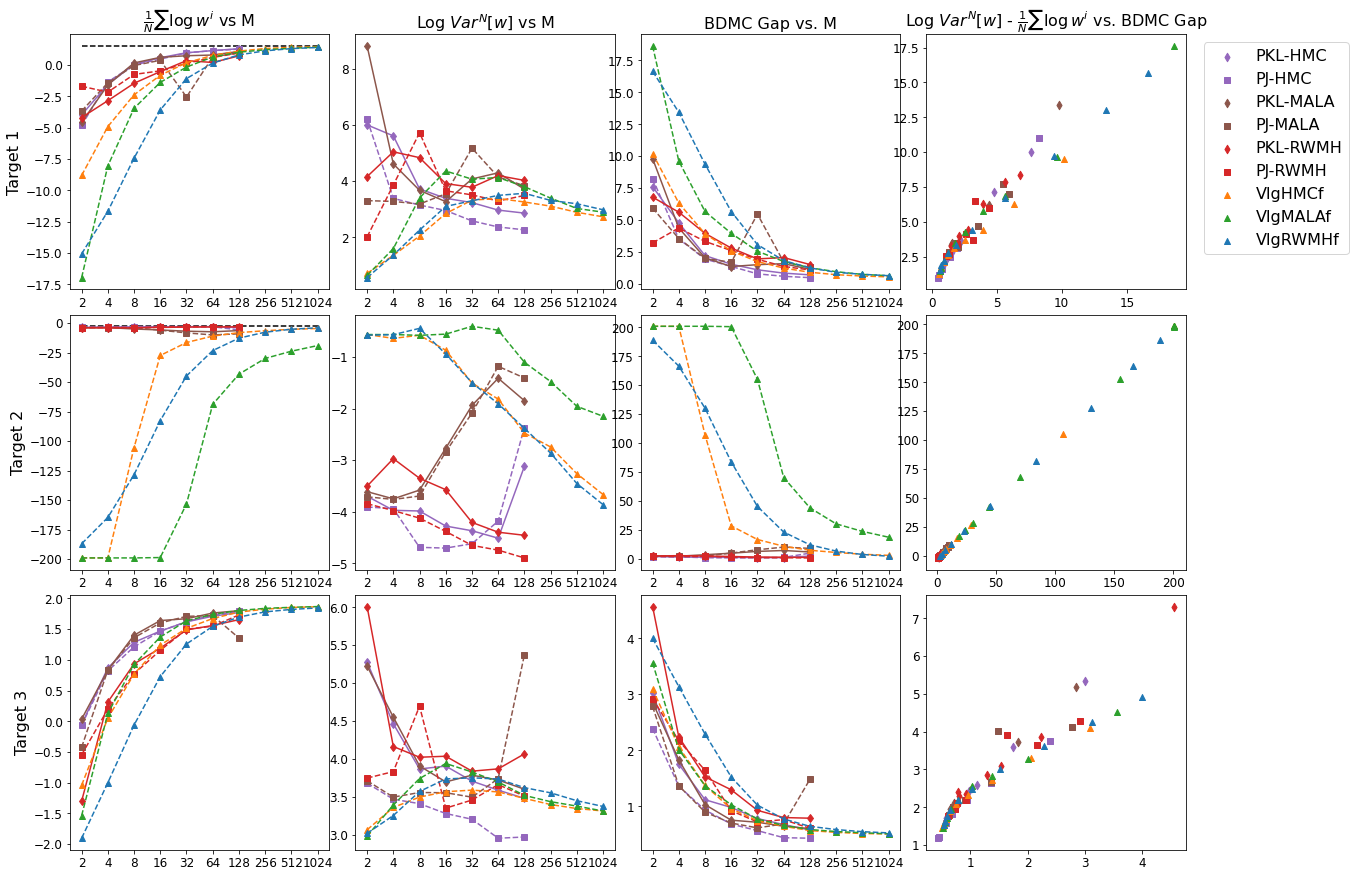

In [2]:
#get Vanilla AIS and MCMC benchmark experiments for synthetic data
#copy from gendoo tests.ipynb
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, pickle

from utils.data import SHAPE, make_dataloaders
from utils.targets import synthetic_targets
from utils.experiments import get_benchmark_experiments, get_dirs
from utils.experiments import Default_ARGS
from utils.dataframe import get_experiment_dataframe, update_dataframe_metrics, group_dataframe
from sampling.utils import init_sampler, load_sampler, train_and_eval_sampler

testname = 'tests/integ'
Default_ARGS.testname = testname
Default_ARGS.bridge_depth = 2
Default_ARGS.bridge_dropout = 0.2
#Default_ARGS.bridge_depth = 0
#Default_ARGS.bridge_dropout = None
Default_ARGS.bridge_q = True
Default_ARGS.bridge_pi = True
Default_ARGS.bridge_hidden_dim = 4
Default_ARGS.context_dim = 0
Default_ARGS.context_net = 'Id'

Default_ARGS.epochs = 100
Default_ARGS.learning_rate = 3e-2
Default_ARGS.test_n_samples = 4096
Default_ARGS.train_anyway = False

#Default_ARGS.transition_update = 'learn'
#Default_ARGS.hmc_n_leapfrogs = 1
test_targets = ['U5', 'U6', 'U1']
Ms = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
samplers = ['ParamAIS', 'Vanilla']
transitions = ['RWMH', 'HMC', 'MALA']
schedules = ['linear']
paths = ['geometric']
losses = ['inverseKL', 'jefferys']
#transition_update = ['grad_std_tune', 'learn']
seeds = [1]
n_sampless = [256]
experiments = get_benchmark_experiments(Default_ARGS, sampler=samplers, seed=seeds,
                            M=Ms, n_samples=n_sampless, path=paths, schedule=schedules, 
                            transition=transitions, target=test_targets, loss=losses, 
                            reinforce_loss=[False], variance_reduction=[False],
                            #transition_update=transition_update,
                            latent_dim=[2], dataset=[None])

ind = {'Vanilla':{'Neal':9, 'RWMH':0, 'HMC':1, 'MALA':2, 'ULA':6}, 
        'ParamAIS':{'Neal':9, 'RWMH':3, 'HMC':4, 'MALA':5, 'ULA':7},
        'OSAIS':{'Neal':9, 'RWMH':3, 'HMC':4, 'MALA':5, 'ULA':7},
        'RealNVP':{'Neal':9, 'RWMH':3, 'HMC':4, 'MALA':5, 'ULA':7},
        'MCMC':{'Neal':9, 'RWMH':3, 'HMC':4, 'MALA':5, 'ULA':7}}
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

linestyles = {'linear': '--', 'geometric': '-', 'jefferys': '--', 'inverseKL': '-', 'grad_std_tune': ':', 'learn':'-.'}
markers = {'linear': '^', 'geometric': 'o', 'jefferys': 's', 'inverseKL': 'd', 'grad_std_tune': 'o', 'learn': '^'}

df = get_experiment_dataframe(experiments)

fig, ax = plt.subplots(nrows=len(test_targets), ncols=4, figsize=(20, 5*len(test_targets))) 

exp_plots = []
for index, row in df.iterrows():
    args = row['args']
    experiment = row['experiment']
    label = row['label']
    
    if row['target_explogZ'] is not None and row['target'] not in exp_plots:
        r = test_targets.index(row['target'])
        ax[r, 0].plot(np.log(Ms), [np.log(row['target_explogZ'])] * len(Ms), c='k', linestyle='--', marker='', label='True')
        exp_plots.append(row['target'])
            
df = update_dataframe_metrics(df)
df = group_dataframe(df)

for index, row in df.iterrows():
    label = row['label']
    
    uptoind = 10
    r = test_targets.index(row['target'])
    color = colors[ind[row['sampler']][row['transition']]]
    if row['sampler'] == 'Vanilla':
        linestyle = linestyles[row['schedule']]
        marker = markers[row['schedule']]
    elif row['sampler'] == 'ParamAIS' or row['sampler'] == 'RealNVP':
        linestyle = linestyles[row['loss']]
        marker = markers[row['loss']]
    elif row['sampler'] == 'OSAIS':
        linestyle = linestyles[row['transition_update']]
        marker = markers[row['loss']]
    ax[r, 0].plot(np.log(row['M']), row['log_w_mean'], c=color, linestyle=linestyle, marker=marker, label=label)
    #if sampler == 'ParamAIS':
    #    ax[0].fill_between(np.log(list(log_ws_std.keys())), [log_ws_mean[k] - log_ws_std[k] for k in log_ws_std.keys()], [log_ws_mean[k] + log_ws_std[k] for k in log_ws_std.keys()], color=color, alpha=0.1)
    ax[r, 0].set_xticks(np.log(Ms[:uptoind]))
    ax[r, 0].set_xticklabels(['{:d}'.format(k) for k in Ms[:uptoind]], fontsize=12)
    ax[r, 0].yaxis.set_tick_params(labelsize=12)
    ax[0, 0].set_title(r'$\frac{1}{N}\sum\log w^i$ vs M', fontsize=16)
    ax[r, 0].set_ylabel('Target {}'.format(r + 1), fontsize=16)
    ax[r, 1].plot(np.log(row['M']), 2*np.log(row['w_std']), c=color, linestyle=linestyle, marker=marker, label=label)
    ax[r, 1].set_xticks(np.log(Ms[:uptoind]))
    ax[r, 1].set_xticklabels(['{:d}'.format(k) for k in Ms[:uptoind]], fontsize=12)
    ax[r, 1].yaxis.set_tick_params(labelsize=12)
    ax[0, 1].set_title(r'Log $Var^N[w]$ vs M', fontsize=16)
    ax[r, 2].plot(np.log(row['M']), row['jefferys'], c=color, linestyle=linestyle, marker=marker, label=label)
    ax[r, 2].set_xticks(np.log(Ms[:uptoind]))
    ax[r, 2].set_xticklabels(['{:d}'.format(k) for k in Ms[:uptoind]], fontsize=12)
    ax[0, 2].set_title(r'BDMC Gap vs. M', fontsize=16)
    ax[r, 2].yaxis.set_tick_params(labelsize=12)                    
    ax[r, 3].scatter(np.array(row['jefferys']), 2*np.log(row['w_std']) - np.array(row['log_w_mean']) , c=color, marker=marker, label=label)
    ax[0, 3].set_title(r'Log $Var^N[w]$ - $\frac{1}{N}\sum\log w^i$ vs. BDMC Gap', fontsize=16)    
    ax[r, 3].yaxis.set_tick_params(labelsize=12)
    ax[r, 3].xaxis.set_tick_params(labelsize=12)
    

ax[0,3].legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=16)

os.makedirs(f'{testname}/plots', exist_ok=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.savefig(f'{testname}/plots/bench_3e-20.22.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches = 0)


=> Loading n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2 on density U5 M=8
Loading checkpoint from: tests/integ/None/1/U5/8/256/ParamAIS/n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2/100_3.000000e-02/checkpoints/best.ckpt
Loaded checkpoint at epoch 97
=> Loading n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2 on density U1 M=8
Loading checkpoint from: tests/integ/None/1/U1/8/256/ParamAIS/n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2/100_3.000000e-02/checkpoints/best.ckpt
Loaded checkpoint at epoch 93
=> Loading n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2 on density U3 M=8
Loading checkpoint from: tests/integ/None/1/U3/8/256/ParamAIS/n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2/100_3.000000e-02/checkpoints/best.ckpt
Loaded checkpoint at epoch 87


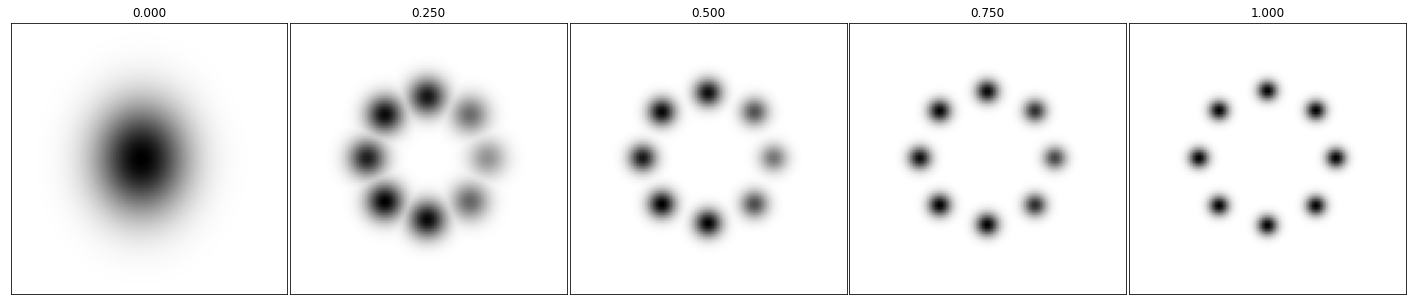

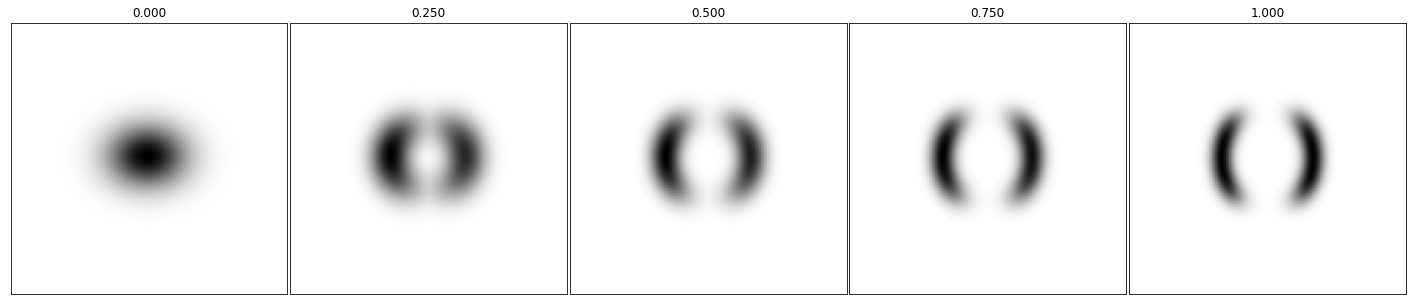

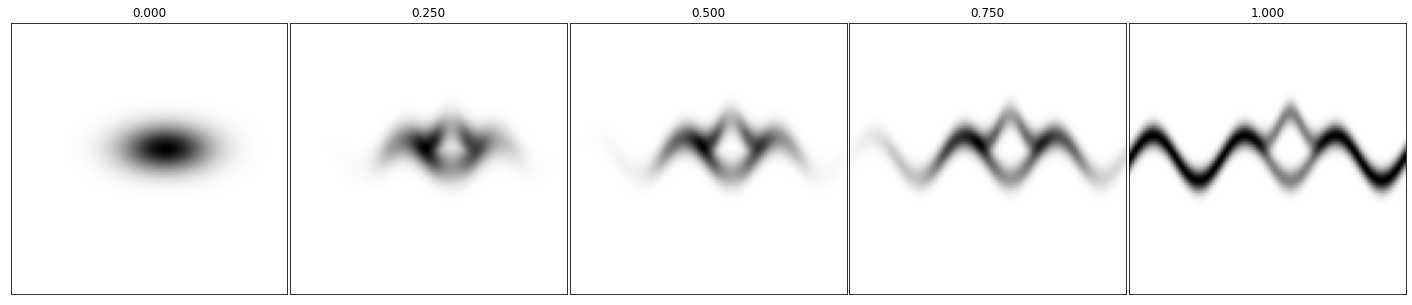

In [3]:
#get annealing plots
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, pickle

from utils.data import SHAPE, make_dataloaders
from utils.targets import synthetic_targets
from utils.experiments import get_benchmark_experiments, get_dirs
from utils.experiments import Default_ARGS
from utils.dataframe import get_experiment_dataframe, update_dataframe_metrics, group_dataframe
from utils.plots import plot_energy_heatmap
from sampling.utils import init_sampler, load_sampler, train_and_eval_sampler

testname = 'tests/integ'
Default_ARGS.testname = testname
Default_ARGS.bridge_depth = 2
Default_ARGS.bridge_dropout = 0.2
#Default_ARGS.bridge_depth = 0
#Default_ARGS.bridge_dropout = None
Default_ARGS.bridge_q = True
Default_ARGS.bridge_pi = True
Default_ARGS.bridge_hidden_dim = 4
Default_ARGS.context_dim = 0
Default_ARGS.context_net = 'Id'

Default_ARGS.epochs = 100
Default_ARGS.learning_rate = 3e-2
Default_ARGS.test_n_samples = 4096
Default_ARGS.train_anyway = False

#Default_ARGS.transition_update = 'learn'
#Default_ARGS.hmc_n_leapfrogs = 1
test_targets = ['U5', 'U1', 'U3']
Ms = [8]
samplers = ['ParamAIS']
transitions = ['HMC']
schedules = ['linear']
paths = ['geometric']
losses = ['jefferys']
#transition_update = ['grad_std_tune', 'learn']
seeds = [1]
n_sampless = [256]
experiments = get_benchmark_experiments(Default_ARGS, sampler=samplers, seed=seeds,
                            M=Ms, n_samples=n_sampless, path=paths, schedule=schedules, 
                            transition=transitions, target=test_targets, loss=losses, 
                            reinforce_loss=[False], variance_reduction=[False],
                            #transition_update=transition_update,
                            latent_dim=[2], dataset=[None])

df = get_experiment_dataframe(experiments)
for index, row in df.iterrows():
    args = row['args']
    experiment = row['experiment']
    label = row['label']
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    target_log_density = synthetic_targets[row['target']]
    save_dir, ckpt_dir, plot_dir, results_dir = get_dirs(args, experiment, make=True)

    if os.path.isfile(os.path.join(save_dir, f'done')):
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
        sampler, dirs, losses, optimizer = load_sampler(args, experiment, target_log_density,
                                                        ckpt='best.ckpt')
        sampler.eval()

        plot_x = None
        betas = torch.tensor(np.linspace(0., 1., 5))
        for i, beta in enumerate(betas):
            plot_energy_heatmap(ax[i], sampler.annealing_path(beta), plot_x)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_title('{:.3f}'.format(beta))
        plt.subplots_adjust(wspace=0.01, hspace=0.01)
    else:
        print(save_dir, 'not done')



=> Loading n_HMC.[0.5].10.1.01l_i_dqp4x2%0.2 on density U5 M=32
Loading checkpoint from: tests/integ/None/1/U5/32/256/ParamAIS/n_HMC.[0.5].10.1.01l_i_dqp4x2%0.2/100_3.000000e-02/checkpoints/best.ckpt
Loaded checkpoint at epoch 93
=> Loading n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2 on density U5 M=32
Loading checkpoint from: tests/integ/None/1/U5/32/256/ParamAIS/n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2/100_3.000000e-02/checkpoints/best.ckpt
Loaded checkpoint at epoch 93
=> Loading n_HMC.[0.5].10.1.01f_lg on density U5 M=32
Couldn't find  tests/integ/None/1/U5/32/4096/Vanilla/n_HMC.[0.5].10.1.01f_lg/checkpoints/best.ckpt
=> Loading n_HMC.[0.5].10.1.01l_i_dqp4x2%0.2 on density U6 M=32
Loading checkpoint from: tests/integ/None/1/U6/32/256/ParamAIS/n_HMC.[0.5].10.1.01l_i_dqp4x2%0.2/100_3.000000e-02/checkpoints/best.ckpt
Loaded checkpoint at epoch 95
=> Loading n_HMC.[0.5].10.1.01l_j_dqp4x2%0.2 on density U6 M=32
Loading checkpoint from: tests/integ/None/1/U6/32/256/ParamAIS/n_HMC.[0.5].10.1.01l_j_dqp4x2%

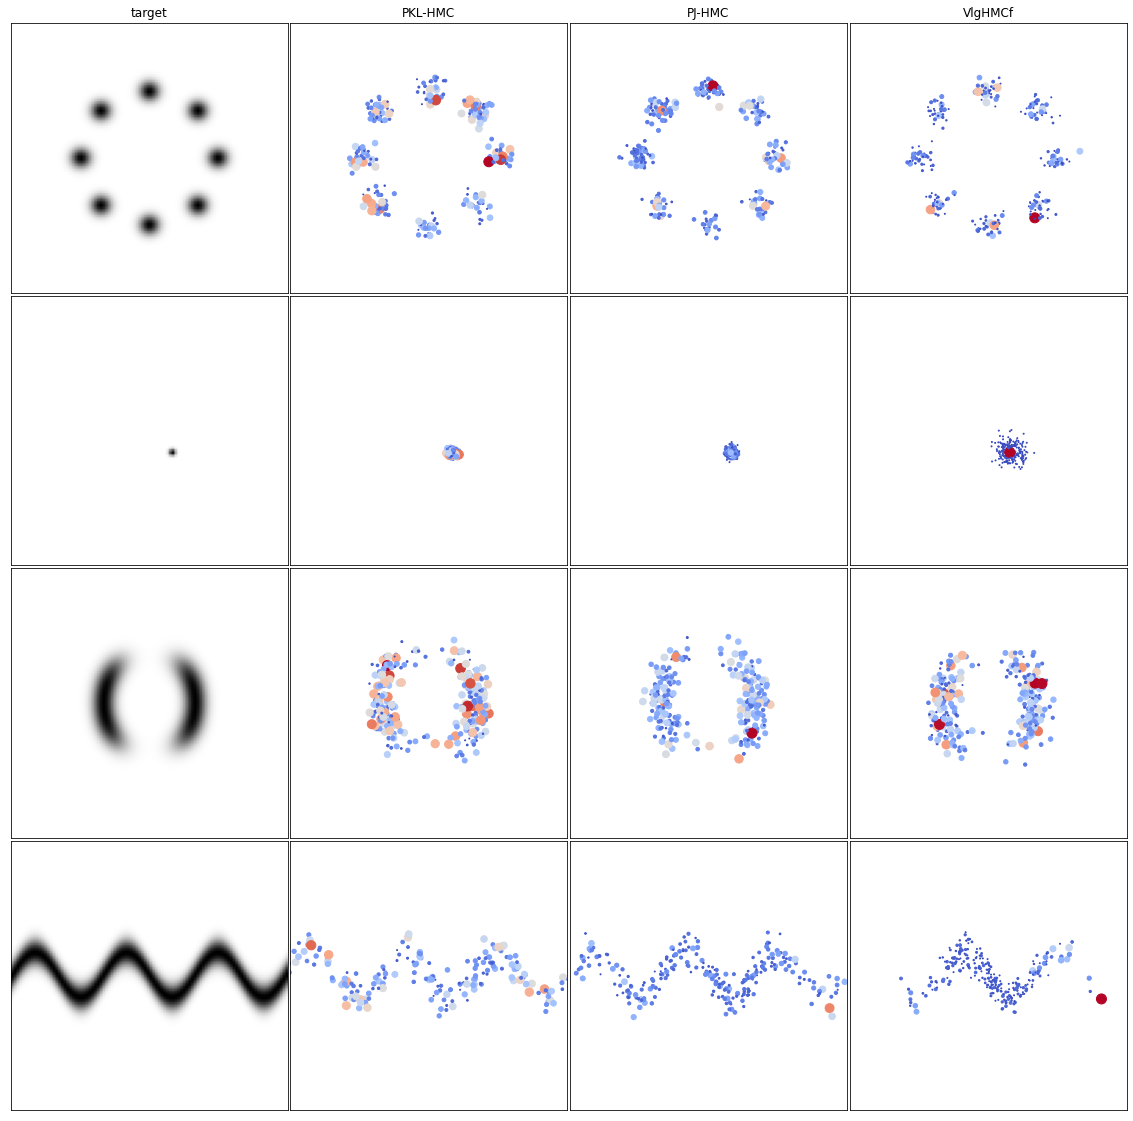

In [4]:
# Synthetic 2d distrbution samples
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, pickle

from utils.data import SHAPE, make_dataloaders
from utils.targets import synthetic_targets
from utils.experiments import get_benchmark_experiments, get_dirs
from utils.experiments import Default_ARGS
from utils.dataframe import get_experiment_dataframe, update_dataframe_metrics, group_dataframe, update_df_stats
from utils.plots import plot_energy_heatmap, plot_particles
from sampling.utils import load_ifnot_init_sampler

testname = 'tests/integ'
Default_ARGS.testname = testname
Default_ARGS.bridge_depth = 2
Default_ARGS.bridge_dropout = 0.2
#Default_ARGS.bridge_depth = 0
#Default_ARGS.bridge_dropout = None
Default_ARGS.bridge_q = True
Default_ARGS.bridge_pi = True
Default_ARGS.bridge_hidden_dim = 4
Default_ARGS.context_dim = 0
Default_ARGS.context_net = 'Id'

Default_ARGS.epochs = 100
Default_ARGS.learning_rate = 3e-2
Default_ARGS.test_n_samples = 4096
Default_ARGS.train_anyway = False

#Default_ARGS.transition_update = 'learn'
#Default_ARGS.hmc_n_leapfrogs = 1
test_targets = ['U5', 'U6', 'U1', 'U2']
Ms = [32]
samplers = ['ParamAIS', 'Vanilla']
transitions = ['HMC']
schedules = ['linear']
paths = ['geometric']
losses = ['inverseKL', 'jefferys']
#transition_update = ['grad_std_tune', 'learn']
seeds = [1]
n_sampless = [256]
experiments = get_benchmark_experiments(Default_ARGS, sampler=samplers, seed=seeds,
                            M=Ms, n_samples=n_sampless, path=paths, schedule=schedules, 
                            transition=transitions, target=test_targets, loss=losses, 
                            reinforce_loss=[False], variance_reduction=[False],
                            #transition_update=transition_update,
                            latent_dim=[2], dataset=[None])

df = get_experiment_dataframe(experiments)
#df = df.reset_index()

for M in Ms:
    targets_ploted = []
    fig, ax = plt.subplots(nrows=len(test_targets), ncols=4, figsize=(20, 5 * len(test_targets)))
    for r, target in enumerate(test_targets):
        df_ = df.loc[(df['M'] == M) & (df['target'] == target)] #& (df['loss'] == loss)]
        l = 1
        for index, row in df_.iterrows():
            args = row['args']
            experiment = row['experiment']
            loss = row['loss']
            label = row['label']

            n_samples = 256
            np.random.seed(args.seed)
            torch.manual_seed(args.seed)

            loaders, normalized = make_dataloaders(dataset=args.dataset, seed=args.seed,
                                                   batch_sizes=args.batch_sizes)
            target_log_density = synthetic_targets[target]
            save_dir, ckpt_dir, plot_dir, results_dir = get_dirs(args, experiment, make=True)

            if os.path.isfile(os.path.join(save_dir, f'done')):
                sampler, dirs, losses, optimizer = load_ifnot_init_sampler(args, experiment, 
                                                                target_log_density, 
                                                                ckpt='best.ckpt', make_dirs=False)
                save_dir, ckpt_dir, plot_dir, results_dir = dirs
                sampler.eval()

                plot_x = None
                if target not in targets_ploted:
                    plot_energy_heatmap(ax[r, 0], target_log_density, plot_x)
                    ax[r, 0].set_xticks([])
                    ax[r, 0].set_yticks([])
                    ax[0, 0].set_title('target')
                z, log_w, reinforce_log_prob, transition_logs = sampler(n_samples, x=None, 
                                                                    update_step_size=False, 
                                                                    log=True)
                zs = transition_logs['z'].reshape(n_samples, target_log_density.data_dim, -1)
                log_ws = transition_logs['log_w'].reshape(n_samples, -1)
                betas = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)
                log_accept_ratio = transition_logs['log_accept_ratio'].reshape(n_samples, -1)

                plot_particles(ax[r, l], zs[:,:,-1], log_ws[:,-1])
                ax[r, l].set_xticks([])
                ax[r, l].set_yticks([])
                ax[0, l].set_title(label)
            l += 1
        plt.subplots_adjust(wspace=0.01, hspace=0.01)



=> Loaded dataset mnist with splits 50000True,10000False,8000False,1600True,400False
generative_models/mnistb/VAE_eb50_1000_[0.0002]_1_1
Loading checkpoint from: generative_models/mnistb/VAE_eb50_1000_[0.0002]_1_1/checkpoints/100.ckpt
Loaded checkpoint at epoch 100
generated_samples


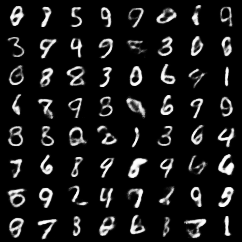

NLL E log w: 99.529, std log w: 26.203
IW log E w: 95.615, std log w: 25.146
ESS  : (1.1 +- 0.3)/16


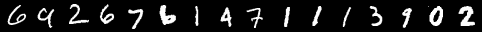

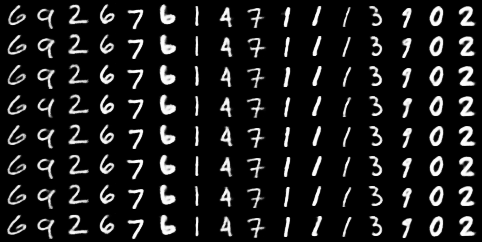

bad nll -120.99192


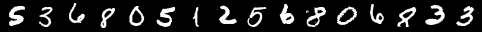

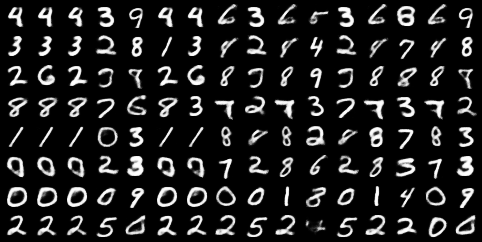

Loading checkpoint from: generative_models/mnistb/VAE_eb50_1000_[0.0002]_1_1/checkpoints/300.ckpt
Loaded checkpoint at epoch 300
generated_samples


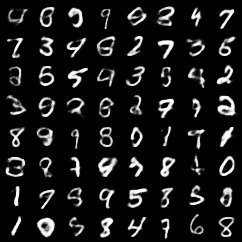

NLL E log w: 98.643, std log w: 26.147
IW log E w: 94.593, std log w: 24.845
ESS  : (1.1 +- 0.3)/16


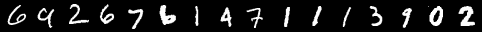

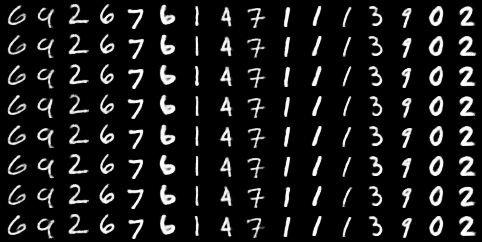

bad nll -120.91412


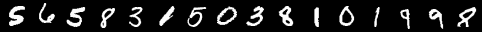

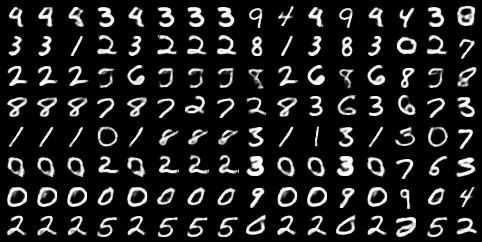

Loading checkpoint from: generative_models/mnistb/VAE_eb50_1000_[0.0002]_1_1/checkpoints/500.ckpt
Loaded checkpoint at epoch 500
generated_samples


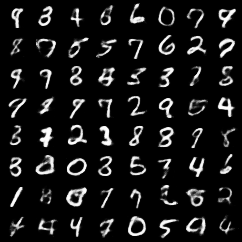

NLL E log w: 98.934, std log w: 26.737
IW log E w: 94.814, std log w: 25.377
ESS  : (1.1 +- 0.3)/16


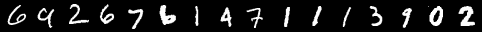

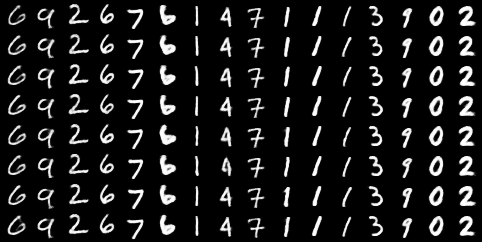

bad nll -123.48669


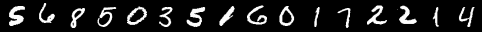

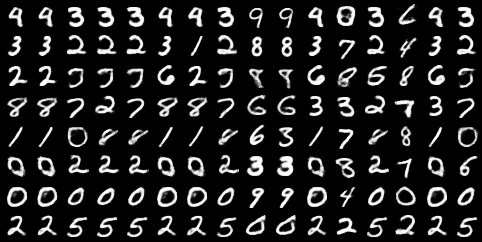

Loading checkpoint from: generative_models/mnistb/VAE_eb50_1000_[0.0002]_1_1/checkpoints/last.ckpt
Loaded checkpoint at epoch 1000
generated_samples


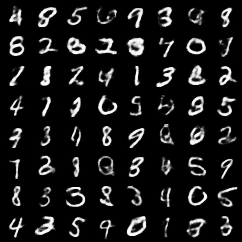

NLL E log w: 99.971, std log w: 27.872
IW log E w: 95.337, std log w: 26.106
ESS  : (1.1 +- 0.3)/16


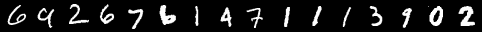

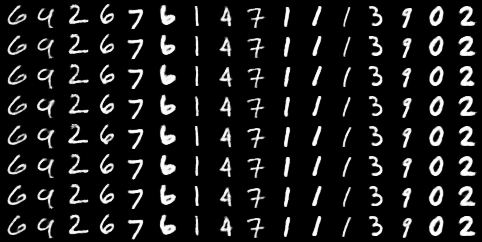

bad nll -124.16222


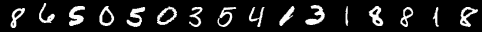

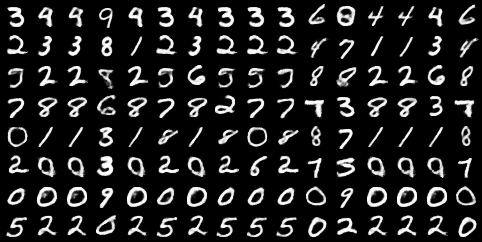

Loading checkpoint from: generative_models/mnistb/VAE_eb50_1000_[0.0002]_1_1/checkpoints/best.ckpt
Loaded checkpoint at epoch 380
generated_samples


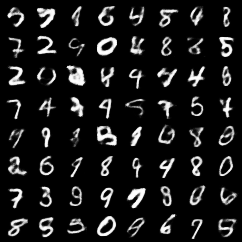

NLL E log w: 98.509, std log w: 26.391
IW log E w: 94.452, std log w: 25.012
ESS  : (1.1 +- 0.3)/16


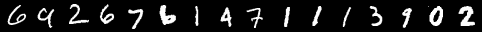

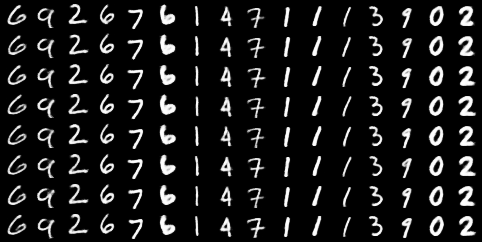

bad nll -120.53696


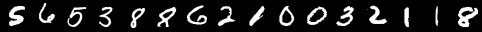

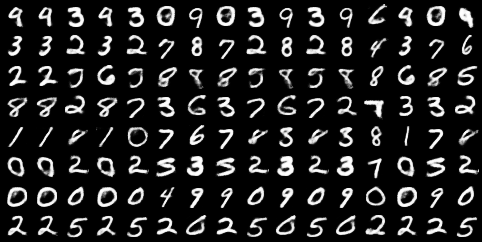

In [5]:
# Generative model test
import warnings
warnings.filterwarnings("ignore")
import torch 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle

from utils.data import SHAPE, make_dataloaders
from models.aux import test, load_checkpoint, get_model
from utils.experiments import get_model_dirs, get_model_default_kwargs
from utils.plots import plot_images
from utils.experiments import Default_ARGS as args

args.testname = 'generative_models'
args.target = 'VAE'
args.dataset = 'mnist'
args.binarize = True
args.dequantize = False
args.latent_dim = 50
args.device = 1
args.seed = 1
n_samples = 16

args, model_kwargs, code = get_model_default_kwargs(args)
save_dir, ckpt_dir, log_dir = get_model_dirs(args, code, make=False)

torch.manual_seed(args.seed)
np.random.seed(args.seed)

loaders, normalized = make_dataloaders(dataset=args.dataset, seed=args.seed,
                                        batch_sizes=args.batch_sizes)

print(save_dir)

last_ckpt = os.path.join(ckpt_dir, 'last.ckpt')    
if not os.path.isfile(last_ckpt):
    print('Couldn\'t find last.ckpt', ckpt_dir)
    
if not os.path.isfile(os.path.join(save_dir, 'done')):
    print('Training not done')

    
for ckpt in ['100.ckpt', '300.ckpt', '500.ckpt', 'last.ckpt', 'best.ckpt']:
    model = get_model(args, model_kwargs, os.path.join(ckpt_dir, ckpt), args.device)
    print('generated_samples')
    test(args, model, loaders[2], normalized, save_dir, n_samples=n_samples, prefix=ckpt)

    

=> Loaded dataset mnist with splits 50000True,10000False,8000False,1600True,400False
generative_models/mnistb/VAE_eb50_1000_[0.0002]_1_1
eb50
Loading checkpoint from: generative_models/mnistb/VAE_eb50_1000_[0.0002]_1_1/checkpoints/500.ckpt
Loaded checkpoint at epoch 500
generated_samples


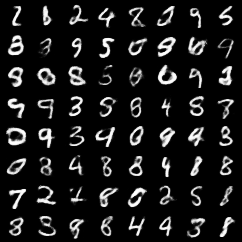

NLL E log w: 95.814, std log w: 27.496
IW log E w: 91.229, std log w: 26.028
ESS  : (1.1 +- 0.3)/16


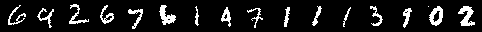

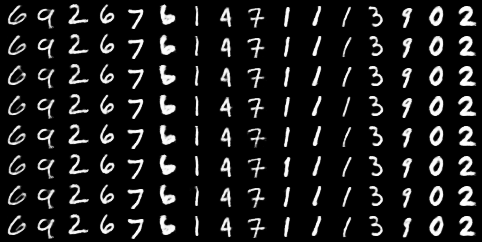

bad nll -120.023346


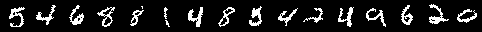

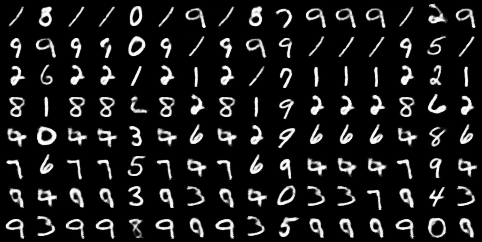

cscs/mnist/1/VAEeb50/16/16/ParamAIS/n_HMC.[0.5].10.1.01l_irv_eqp32x0%None/100_1.000000e-02
=> Training n_HMC.[0.5].10.1.01l_irv_eqp32x0%None on density VAEeb50 M=16
=> Loading n_HMC.[0.5].10.1.01l_irv_eqp32x0%None on density VAEeb50 M=16
Loading checkpoint from: cscs/mnist/1/VAEeb50/16/16/ParamAIS/n_HMC.[0.5].10.1.01l_irv_eqp32x0%None/100_1.000000e-02/checkpoints/best.ckpt
Loaded checkpoint at epoch 98
Yeay already got that one!
=> Evaluating after...
Sampling time 0:00:00.717
log Z: None, E log w: -244.295, std log w: 74.390
log Z: None, log E w: -134.344, std log w: 43.190
Z    : None, E w    : 0.000, std w    : 0.000
ESS  : (1.1 +- 0.2)/16
torch.Size([16, 8000, 50]) torch.Size([16, 8000])
log Z: None, E log w: -244.295, std log w: 74.390
log Z: None, log E w: -134.344, std log w: 43.190
Z    : None, E w    : 0.000, std w    : 0.000
ESS  : (1.1 +- 0.2)/16
skip couter 0 nan counter 0 early stop False skip break False
torch.Size([16, 16, 50]) here torch.Size([16, 1, 28, 28]) torch.Size

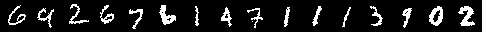

ais reconstruction


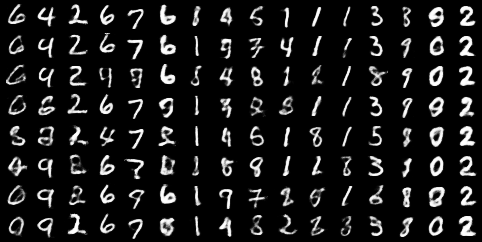

bad_samples tensor(-571.1047)


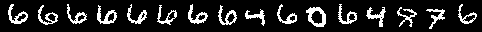

bad sample reconstruction


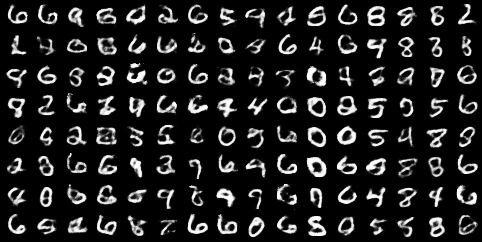

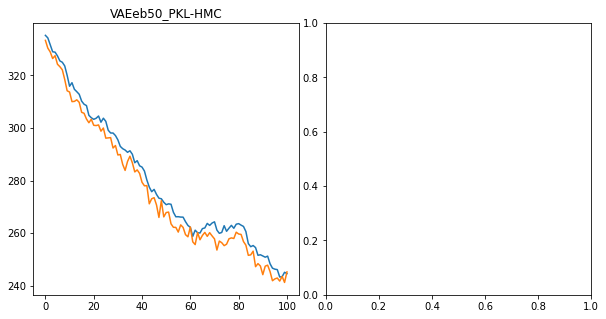

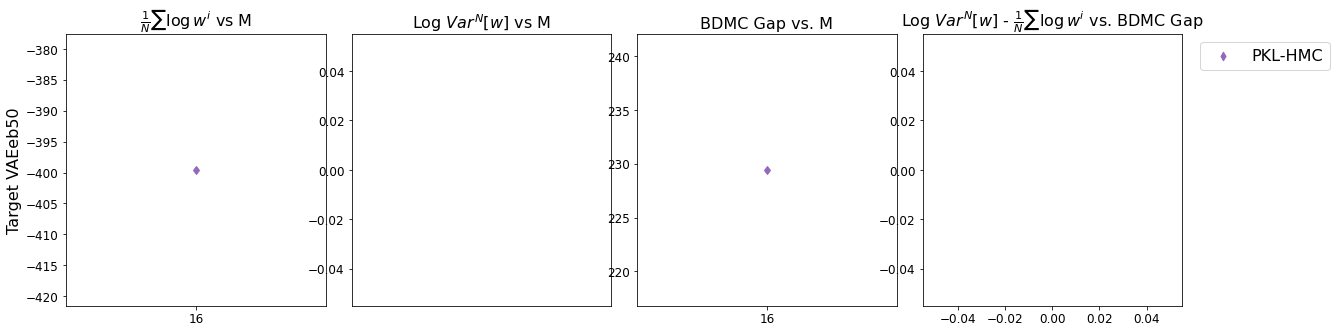

In [1]:
# AIS partition function estimation for generative models and synthetic targets
import warnings
warnings.filterwarnings("ignore")
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle

from models.aux import test, load_checkpoint, get_model
from utils.data import make_dataloaders, SHAPE
from utils.targets import synthetic_targets
from utils.experiments import get_model_dirs, get_model_default_kwargs, get_dirs, get_benchmark_experiments
from utils.experiments import Default_ARGS as args
from utils.plots import plot_images
from utils.aux import repeat_data, get_bad_batch
from utils.dataframe import get_experiment_dataframe, update_dataframe_metrics, group_dataframe
from sampling.losses import inverseKL, jefferys
from sampling.utils import init_sampler, load_sampler, weight_stats, train_and_eval_sampler

save_img = False
testname = 'cscs'
args.testname = testname
samplers = ['ParamAIS']
args.target = 'VAE'
paths = ['geometric']
schedules = ['linear']
Ms = [16]
args.hmc_n_leapfrogs=1
args.transition_update='learn'
args.proposal = 'normal'
args.proposal_kwargs = {}
transitions = ['HMC']
args.device = 2
args.seed = 1
args.train_anyway = False
args.dataset = 'mnist'
args.binarize = True
args.dequantize = False
args.batch_sizes = [16, 16, 1024, 16, 16]
n_sampless = [16]
args.latent_dim = 50
args.n_samples = 16
args.test_n_samples = 16

losses = ['inverseKL']
args.reinforce_loss = True
args.variance_reduction = True
args.bridge_hidden_dim = 32
args.bridge_depth = 0
args.bridge_q = True
args.bridge_pi = True

args.context_dim = 50
args.context_net = 'wu-wide'
args.bridge_dropout = None
args.epochs = 100
args.learning_rate = 1e-2
    
loaders, normalized = make_dataloaders(dataset=args.dataset, batch_sizes=args.batch_sizes, 
                           ais_split=True, seed=args.seed, binarize=args.binarize, 
                           dequantize=args.dequantize)
    
data_shape = SHAPE[args.dataset]

target_log_density = None
if args.target in synthetic_targets.keys():
    target_log_density = synthetic_targets[args.target]
else:
    model_args, model_kwargs, code = get_model_default_kwargs(args)
    save_dir, ckpt_dir, log_dir = get_model_dirs(model_args, code, make=False)
    print(save_dir)
    print(code)

    args.target = f'{model_args.model}{code}'
    
    ckpt = os.path.join(ckpt_dir, '500.ckpt')    
    if not os.path.isfile(ckpt):
        print(f'Couldn\'t find the {ckpt}')
        model = None
        
    else:
        model = get_model(model_args, model_kwargs, ckpt, args.device)
        print('generated_samples')
        test(model_args, model, loaders[2], normalized, save_dir, n_samples=args.n_samples, prefix=f'{args.target}_{ckpt}', save=False)
        log_var = torch.ones((1,) + tuple(SHAPE[model_args.dataset])).cuda() * (-np.log(2.))
        target_log_density = lambda z, x: model.log_joint_density(z, x, None, log_var)
        logZ = None

            
ind = {'Vanilla':{'Neal':9, 'RWMH':0, 'HMC':1, 'MALA':2, 'ULA':6}, 
        'ParamAIS':{'Neal':9, 'RWMH':3, 'HMC':4, 'MALA':5, 'ULA':7},
        'MCMC':{'Neal':9, 'RWMH':3, 'HMC':4, 'MALA':5, 'ULA':7},
        'ARAIS':{'Neal':9, 'RWMH':3, 'HMC':4, 'MALA':5, 'ULA':7},}
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

linestyles = {'linear': '--', 'geometric': '-', 'jefferys': '--', 'inverseKL': '-'}
markers = {'linear': '^', 'geometric': 'o', 'jefferys': 's', 'inverseKL': 'd'}

if target_log_density is not None:            
    experiments = get_benchmark_experiments(args, sampler=samplers, M=Ms, n_samples=n_sampless, path=paths, schedule=schedules, 
                            transition=transitions, loss=losses, transition_update=[args.transition_update])
    df = get_experiment_dataframe(experiments)

    for index, row in df.iterrows():
        args = row['args']
        experiment = row['experiment']
        label = row['label']

        np.random.seed(args.seed)
        torch.manual_seed(args.seed)

        save_dir, ckpt_dir, plot_dir, results_dir = get_dirs(args, experiment, make=True)
        print(save_dir)
        
        sampler = train_and_eval_sampler(args, experiment, target_log_density, loaders, log=False)
        prefix = 'after'
        eval_pickle = os.path.join(results_dir, f'{prefix}_eval_transitions.pkl')
        if not os.path.isfile(eval_pickle):
            print('no pickle', eval_pickle)
            found_pickle = False
        else:
            found_pickle = True
            with open(eval_pickle, 'rb') as f:
                pkl = pickle.load(f)
            zs = pkl['z']
            log_ws = pkl['log_w']
            print(zs.shape, log_ws.shape)
            weight_stats(log_ws, target_log_density, args.test_n_samples, prefix, True) 
            bad_x, bad_z, bad_ll, bad_ind = get_bad_batch(zs, log_ws, loaders[2], args.test_n_samples, 16)

            #if args.sampler in ['Vanilla', 'MCMC'] and args.transition_update == 'fixed':
            #    sampler, _ = init_sampler(args, experiment, target_log_density, make_dirs=False)
            #else:
            #    sampler, _, _, _ = load_sampler(args, experiment, target_log_density, ckpt='best.ckpt')

            if args.sampler == 'ParamAIS':
                with open(os.path.join(results_dir, 'losses.pkl'), 'rb') as f:
                    losses = pickle.load(f)

                print(f"skip couter {losses['skip_counter']} nan counter {losses['nan_counter']} early stop {losses['early_stop']} skip break {losses['skip_break']}")
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
                ax[0].plot(range(len(losses['train'])), losses['train'])
                ax[0].plot(range(len(losses['val'])), losses['val'])
                ax[0].set_title(f'{model_args.model}{code}_{label}')
                plt.subplots_adjust(wspace=0.1, hspace=0.1)
                #plt.savefig(f'recon_plots/{model_args.model}{code}_{label}_loss.png', format='png', dpi=120, transparent=True, bbox_inches='tight', pad_inches = 0)

            rows = 8
            rx = []
            N = 0
            for batch in loaders[2]:
                x, _ = batch
                x = x.cuda()
                N += x.shape[0]
                rx.append(x[:16])
                if N > 16:
                    break

            x = torch.cat(rx, dim=0)
            print(bad_z.shape, 'here', x.shape, zs.shape)
            #z_ais, log_w_, reinforce_log_prob_, transition_logs = sampler(rows, x=x, update_step_size=False, log=False)
            z_ais = zs[:rows][:,:16].reshape(-1, args.latent_dim)
            print(z_ais.shape)
            model.save_gen(None, x, None, 16, save_dir='recon_plots', 
                           prefix=f'{model_args.model}{code}_data', save=save_img)
            print('ais reconstruction')
            model.save_gen(z_ais, None, None, 16, save_dir='recon_plots',
                           prefix=f'{model_args.model}{code}_{label}_eval', save=save_img)
            print('bad_samples', bad_ll.mean())
            model.save_gen(None, bad_x, None, 16, save_dir='recon_plots',
                           prefix=f'{model_args.model}{code}_{label}_bad', save=save_img)
            print('bad sample reconstruction')
            model.save_gen(bad_z[:8].reshape(-1, args.latent_dim), None, None, 16, save_dir='recon_plots',
                           prefix=f'{model_args.model}{code}_{label}_bad_recon', save=save_img)

    if found_pickle:
        df = update_dataframe_metrics(df)
        df = group_dataframe(df)    

        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5)) 
        for index, row in df.iterrows():
            label = row['label']

            uptoind = 10
            color = colors[ind[row['sampler']][row['transition']]]
            if row['sampler'] == 'Vanilla':
                linestyle = linestyles[row['schedule']]
                marker = markers[row['schedule']]
            elif row['sampler'] == 'ParamAIS' or row['sampler'] == 'ARAIS':
                linestyle = linestyles[row['loss']]
                marker = markers[row['loss']]
            ax[0].plot(np.log(row['M']), row['log_w_mean'], c=color, linestyle=linestyle, marker=marker, label=label)
            #if sampler == 'ParamAIS':
            #    ax[0].fill_between(np.log(list(log_ws_std.keys())), [log_ws_mean[k] - log_ws_std[k] for k in log_ws_std.keys()], [log_ws_mean[k] + log_ws_std[k] for k in log_ws_std.keys()], color=color, alpha=0.1)
            ax[0].set_xticks(np.log(Ms[:uptoind]))
            ax[0].set_xticklabels(['{:d}'.format(k) for k in Ms[:uptoind]], fontsize=12)
            ax[0].yaxis.set_tick_params(labelsize=12)
            ax[0].set_title(r'$\frac{1}{N}\sum\log w^i$ vs M', fontsize=16)
            ax[0].set_ylabel('Target {}'.format(args.target), fontsize=16)
            ax[1].plot(np.log(row['M']), 2*np.log(row['w_std']), c=color, linestyle=linestyle, marker=marker, label=label)
            ax[1].set_xticks(np.log(Ms[:uptoind]))
            ax[1].set_xticklabels(['{:d}'.format(k) for k in Ms[:uptoind]], fontsize=12)
            ax[1].yaxis.set_tick_params(labelsize=12)
            ax[1].set_title(r'Log $Var^N[w]$ vs M', fontsize=16)
            ##if exp_logZ is not None and transition == 'Neal':
            ##    ax[m, 2].plot(np.log(list(sym_losses.keys())), [sym_losses[k] for k in sym_losses.keys()], c='k', linestyle=None, marker='', label='True')
            ax[2].plot(np.log(row['M']), row['jefferys'], c=color, linestyle=linestyle, marker=marker, label=label)
            ax[2].set_xticks(np.log(Ms[:uptoind]))
            ax[2].set_xticklabels(['{:d}'.format(k) for k in Ms[:uptoind]], fontsize=12)
            ax[2].set_title(r'BDMC Gap vs. M', fontsize=16)
            ax[2].yaxis.set_tick_params(labelsize=12)                    
            ax[3].scatter(np.array(row['jefferys']), 2*np.log(row['w_std']) - np.array(row['log_w_mean']) , c=color, marker=marker, label=label)
            ax[3].set_title(r'Log $Var^N[w]$ - $\frac{1}{N}\sum\log w^i$ vs. BDMC Gap', fontsize=16)    
            ax[3].yaxis.set_tick_params(labelsize=12)
            ax[3].xaxis.set_tick_params(labelsize=12)


        ax[3].legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=16)

        os.makedirs(f'{testname}/plots', exist_ok=True)
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        
